In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.optimizers import adam_v2
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import cv2
from cv2 import imread, createCLAHE # read and equalize images

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from skimage.util import montage as montage2d

import os
from glob import glob
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

Create MASK directory of TBX11, DA&DB, MC&Shenzhen dataset

In [2]:
!mkdir /home/TBX11K/masks

#### Load Model and initialize weight

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [4]:
from keras.models import load_model
model = load_model('/home/Unet-Models/unet-base-val-loss-lre3.hdf5',
                   custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef})
model.summary()

2022-08-18 19:04:01.492685: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-18 19:04:01.492753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_19[0][0]']              
                                )                                                           

#### Generate Masks for TBX11K datasets

In [5]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
CLIP_LIMIT = 40
GRID_SIZE = (8,8)


def load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    
    img_eq= cv2.equalizeHist(img)
    
    clahe = cv2.createCLAHE(clipLimit= CLIP_LIMIT, tileGridSize=GRID_SIZE)
    img = clahe.apply(img_eq)
    img = img / 255
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def img_generator(img_files, target_size=(256,256)):
    for filename in img_files:
        yield load_image(filename, target_size)
        
def save_result(save_path, npyfile,res_files):
    for i, item in enumerate(npyfile):
        result_file = res_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename = os.path.basename(result_file)
        result_file = os.path.join(save_path,filename)

        cv2.imwrite(result_file, img)

#### TBX11K - Train and Validation Mask Generation

In [6]:
TBX11K_MASK_DIR='/home/TBX11K/masks'
TBX11K_IMGS = '/home/TBX11K/imgs'

img_files = []
for folder in ['extra','health','sick','tb']:
    path = os.path.join(TBX11K_IMGS,folder,'**/*.png')
    for filename in glob(path, recursive=True):
        img_files.append(filename)

image_gen = img_generator(img_files, target_size=(256,256))
results = model.predict(image_gen, len(img_files), verbose=1)
save_result(TBX11K_MASK_DIR, results, img_files)

2022-08-18 19:04:09.944540: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


8872/8872 [==============================] - 96s 11ms/step


2022-08-18 19:05:44.806252: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2325741568 exceeds 10% of free system memory.


100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


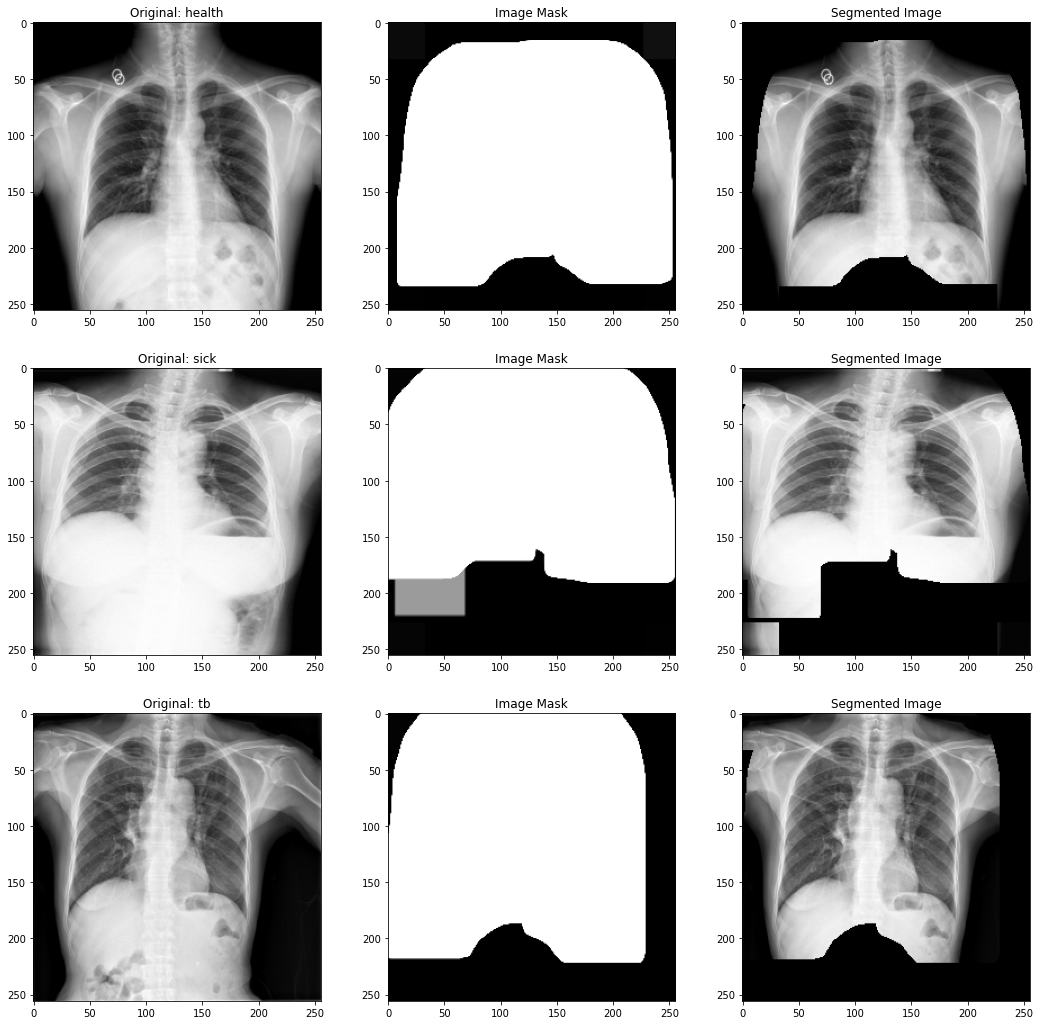

In [7]:
TBX11K_MASK_DIR='/home/TBX11K/masks'
TBX11K_IMGS = '/home/TBX11K/imgs'
fig, axs = plt.subplots(3,3, figsize=(18, 18))
inputs = [TBX11K_IMGS]
classes = ['health','sick','tb']
DILATE_KERNEL = np.ones((16, 16), np.uint8)
ctr = 0
for input_dir in tqdm(inputs):
    for class_dir in classes:
        img_files = glob(os.path.join(input_dir,class_dir , '*.png'))
        filename = img_files[200]
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(256,256))
        axs[ctr, 0].set_title("Original: "+class_dir)
        axs[ctr, 0].imshow(image,cmap='gray')
        
        basename = os.path.basename(filename)
        mask_file = os.path.join(TBX11K_MASK_DIR,basename)
        mask_img = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        mask_dilate = cv2.dilate(mask_img, DILATE_KERNEL, iterations=4)
        #print('mas: ',mask_dilate.shape)
        axs[ctr, 1].set_title("Image Mask")
        axs[ctr, 1].imshow(mask_dilate,cmap='gray')
        
        masked_cxr = cv2.bitwise_and(image,image,mask=mask_dilate)
        #masked_cxr = cv2.addWeighted(image, 0.85, mask_dilate, 0.15, 0)
        
        result = image.copy()
        result[mask_dilate==0] = 0
        
        
        axs[ctr, 2].set_title("Segmented Image")
        axs[ctr, 2].imshow(result,cmap='gray')
        ctr += 1
        
plt.show()

In [8]:
TBX11K_MASK_DIR='/home/TBX11K/masks'
TBX11K_IMGS = '/home/Model-Evaluation'

img_files = glob(os.path.join(TBX11K_IMGS,'Montgomery','CXR_png','*.png'))
sh_files = glob(os.path.join(TBX11K_IMGS,'Shenzhen','CXR_png','*.png'))
img_files.extend(sh_files)
image_gen = img_generator(img_files, target_size=(256,256))
results = model.predict(image_gen, len(img_files), verbose=1)
save_result(TBX11K_MASK_DIR, results, img_files)

800/800 [==============================] - 88s 110ms/step
